<img src="../../../docs/images/DSPy8.png" alt="DSPy7 Image" height="150"/>

# Using __<ins>M</ins>ulti-stage <ins>I</ins>nstruction <ins>P</ins>roposal & <ins>O</ins>ptimization (MIPROv2)__ in DSPy
[![colab-badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/dspy/blob/main/examples/nli/scone/scone_with_MIPRO.ipynb)

### FAQ 🙋
#### 1) How does MIPRO work?
At a high level, the MIPRO program optimizer works by first __proposing__ candidate fewshot example sets and instructions for each prompt in your program, and then __optimizing__ over these fewshot example sets and instructions as hyperparameters for a specified number of batches. Each batch, the optimizer evaluates different combinations of prompts on a subset of training inputs, which allows it to learn which combinations yield the best performance.

#### 2) How much will MIPRO cost me to run?
Note that __this notebook__ is free to run, because all LM calls have been cached. However, when using an optimizer on your own program, here is a breakdown of the upper bound of the number of calls to the task model and prompt model respectively:

- **Task model calls**: MIPRO makes up to __O(TxPxM)__ task model calls if you run without minibatching, where T is the number of batches, P is the number of prompts in the program, and M is the size of the train set. This is because the model is evaluating the program on the train set each batch.  If you run **with minibatching** you can reduce calls even further to __O(TxPxB)__ where **B** is the minibatch size.  Note that every few steps (a parameter you set) MIPRO will also run a full eval over all **M** examples.

- **Prompt model calls**: MIPRO makes up to N*P+10+(P+1) prompt model calls, where N is the number of instruction / fewshot example set candidates to generate for each prompt, and P is the number of prompts in the program. The extra 10 calls comes from generating a summary of the data in the training set, which we use in the meta prompt to create better instructions.  The extra (P+1) comes from program summarization where the proposer LLM will look at the program code and try to describe what each module does and what the whole program does.

#### 3) How should I configure the hyperparameters?
We have yet to run full hyperparameter sweeps with MIPRO, but based off of initial experimintation, we'd recommend the following:
- __Batch num__: Gains can be seen after about 20-30 batches. However, 100-200 batches can help with adding on additional marginal gains.
- __num candidates__: This hyperparameter controls the number of candidate prompts and fewshot example sets that are generated to optimize over. With more batches and less prompts to optimize, we can set n to be higher, as we have more batches to explore different combinations of prompts. If your program has between 2-3 modules and is the `num_batches=30`, we'd recommend ~`n=10`. If n is higher (say `n=100`), then we can go higher to ~`n=15`. If you have a program with only 1 module and are keeping the program 0-shot (ie. no fewshot examples), then `num_batches` should be set to equal `n`, because each batch can explore a new instruction.
- __Training set size__: Between 100 and 500 training examples are recommended, however MIPROv2 can still work well with fewer. Increasing the training set size can help prevent overfitting, and only slightly increases cost for the full evaluation runs.

#### 4) What should I do if I want to reduce the cost?
You can always update hyperparameters accordingly, such as using a smaller train set, using less batches, or using a program with less modules.  You should take advantage of minibatching.
Alternatively, one strategy would be to optimize using a cheaper task model (ie. locally hosted Llama-3), as initial experiments have shown that prompts optimized for a smaller model also transfer to working well on a larger model.

### 0] Setup

First, we will install __DSPy__ if it's not there already. We'll also __load in the cached requests__ for this tasks, so that we don't actually need to call any LMs for this notebook. We'll also load in our pre optimized program from hugging face to inspect later.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab  # noqa: F401
    repo_path = 'dspy'

    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)


import pkg_resources # Install the package if it's not installed
if "dspy-ai" not in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai==2.4.17
    !pip install openai~=1.12
    !pip install -e $repo_path
    !pip install --upgrade cloudpickle==3.0.0

from huggingface_hub import hf_hub_download
import zipfile

repo_id = 'MichaelR207/MIPRO_notebook_cache_scone'
cache_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='MIPRO_notebook_cache.zip')
compiled_program_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='compiled_program.dspy')
trial_logs_file_path = hf_hub_download(repo_id=repo_id, repo_type='dataset', filename='trial_logs.pickle')

with zipfile.ZipFile(cache_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

os.environ["DSP_NOTEBOOK_CACHEDIR"] = f"{os.getcwd()}/MIPRO_notebook_cache"

import dspy
import pandas as pd
import random
from dspy.evaluate import Evaluate

/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will also specify the __prompt LM model__ (in this case GPT 3.5), the __task LM model__ (Llama 3 8B)

In [2]:

### NOTE: if you'd like to run this code without a cache, you can remove these lines to configure your OPEN AI key ###
# os.environ['OPENAI_API_KEY'] = "TODO: ADD YOUR OPEN AI KEY HERE"
# openai.api_key = os.environ.get('OPENAI_API_KEY')
# openai.api_base = "https://api.openai.com/v1"

prompt_model_name = "gpt-3.5-turbo-1106"
task_model_name = "meta-llama/Meta-Llama-3-8B"

prompt_model = dspy.OpenAI(model=prompt_model_name, max_tokens=1000, stop=["\n\n", "\n---"])
task_model = dspy.HFClientVLLM(
    model=task_model_name,
    port=7410,
    url=["http://future-hgx-2:7500", "http://future-hgx-2:7501", "http://future-hgx-2:7502", "http://future-hgx-2:7503", "http://future-hgx-2:7504", "http://future-hgx-2:7505", "http://future-hgx-2:7506", "http://future-hgx-2:7507"],
    max_tokens=1000,
    stop=["\n\n", "\n---", "assistant"],
)

dspy.settings.configure(lm=task_model)

### 1] Define Task

Here, we'll define the program that we'd like to run, which is a multihop [...] (we can say that it was loosely inspired by a certain paper). We additionally load in the data, and define how we'd like to evaluate this task.

In [3]:
!git clone https://github.com/selenashe/ScoNe.git

fatal: destination path 'ScoNe' already exists and is not an empty directory.


In [4]:
class ScoNeSignature(dspy.Signature):
    ("""context, question -> answer""")

    context = dspy.InputField()
    question = dspy.InputField()
    answer = dspy.OutputField(desc="Yes or No")

class ScoNeCoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.ChainOfThought(ScoNeSignature)

    def forward(self, context, question):
        return self.generate_answer(context=context, question=question)

In [5]:
def load_scone(dirname):
    dfs = []
    filenames = ['one_not_scoped.csv', 'one_scoped.csv', 'no_negation.csv', 'one_scoped_one_not_scoped.csv', 'two_scoped.csv', 'two_not_scoped.csv']

    for filename in filenames:
        filename = os.path.join(dirname, filename)
        df = pd.read_csv(filename, index_col=0)
        df['category'] = os.path.basename(filename).replace(".csv", "")
        dfs.append(df)
    data_df = pd.concat(dfs)

    def as_example(row):
        # The 'one_scoped' file is from an earlier dataset, MoNLI, and
        # so is formatted a bit differently:
        suffix = '' if row['category'] == 'one_scoped' else '_edited'
        # Reformat the hypothesis to be an embedded clause in a question:
        hkey = 'sentence2' + suffix
        question = row[hkey][0].lower() + row[hkey][1: ].strip(".")
        question = f"Can we logically conclude for sure that {question}?"
        # Binary task formulation:
        label = "Yes" if row['gold_label' + suffix] == 'entailment' else "No"
        return dspy.Example({
            "context": row['sentence1' + suffix],
            "question": question,
            "answer": label,
            "category": row['category'],
        }).with_inputs("context", "question")
    return list(data_df.apply(as_example, axis=1).values)

In [6]:
# Load and configure the datasets.
all_train = load_scone("ScoNe/scone_nli/train")

random.seed(1)
random.shuffle(all_train)

# 1000 random train, 500 random dev:
trainset, valset, testset = all_train[: 200], all_train[200: 400], all_train[400: 600]

In [7]:
# Set up metrics
NUM_THREADS = 10
metric = dspy.evaluate.answer_exact_match

kwargs = dict(num_threads=NUM_THREADS, display_progress=True)
evaluate = Evaluate(devset=valset, metric=metric, **kwargs)

program = ScoNeCoT()

### 2] Baseline Evaluation
Now, we'll quickly evaluate our baseline program so that we can see how the performance using the Prompt Optimizer compares. We should see performance of about __58.0%__ on our trainset, __49.5%__ on our valset, and __55.0%__ on our testset.

In [8]:
baseline_train_score = evaluate(program,devset=trainset)
baseline_eval_score = evaluate(program, devset=valset)
baseline_test_score = evaluate(program, devset=testset)

Average Metric: 110 / 200  (55.0): 100%|██████████| 200/200 [00:00<00:00, 647.97it/s]


### 3] Optimizing with MIPRO

Now let's get into the key method in this notebook - optimizing our program with MIPRO!

#### 3a] Compile Program
First, we'll get our optimized program. By default, we set `LOAD_PRECOMPILED_PROGRAM` to `True`, so that you can quickly access a program we've precompiled for you. However, if you wish to optimize yourself, `LOAD_PRECOMPILED_PROGRAM` can be set to `False` (though please note that this will require adding in your own LM API keys in the __Setup__ section above).

MIPRO only needs a metric, DSPy module, and training set to see huge gains on your task!  You can instantiate a MIPRO Optimizer and compile in just two lines:
```python
teleprompter = MIPROv2(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature)
compiled_program = teleprompter.compile(program, trainset=trainset, valset=valset, num_batches=batches, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)
```

In [9]:
import cloudpickle as pickle
from dspy.teleprompt import MIPROv2

LOAD_PRECOMPILED_PROGRAM = False
compiled_program = program.deepcopy()

# We can load the precompiled program, but since scone is quick to compile, we can also compile it from scratch
if LOAD_PRECOMPILED_PROGRAM:
    # Load the data from the file
    compiled_program.load(compiled_program_file_path)
    with open(trial_logs_file_path, "rb") as f:
        trial_logs = pickle.load(f)
    compiled_program.trial_logs = trial_logs
# Otherwise, if desired, the program can be compiled from scratch
else:
    # Define hyperparameters:
    N = 10 # The number of instructions and fewshot examples that we will generate and optimize over
    batches = 30 # The number of optimization batches to be run (we will test out a new combination of instructions and fewshot examples in each trial)
    temperature = 1.0 # The temperature configured for generating new instructions

    # Compile
    eval_kwargs = dict(num_threads=16, display_progress=True, display_table=0)
    teleprompter = MIPROv2(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=N, init_temperature=temperature, verbose=True)
    print(trainset[:10])
    compiled_program = teleprompter.compile(program, trainset=trainset, valset=valset, num_batches=batches, max_bootstrapped_demos=1,max_labeled_demos=2, eval_kwargs=eval_kwargs)

/Users/michaelryan/Documents/School/Stanford/Research/dspy_official/dspy/examples/nli/scone/MIPRO_notebook_cache/compiler
[Example({'context': 'The cowboy did not tell other people that he fall off a horse at the competition.', 'question': 'Can we logically conclude for sure that the cowboy did not tell other people that he fall off a bronco at the competition?', 'answer': 'No', 'category': 'one_not_scoped'}) (input_keys={'context', 'question'}), Example({'context': 'The woman not crying is not wearing rings.', 'question': 'Can we logically conclude for sure that the woman not crying is not wearing jewelry?', 'answer': 'No', 'category': 'one_scoped_one_not_scoped'}) (input_keys={'context', 'question'}), Example({'context': 'The people were not trying to keep their voices down so they woke a woman who is not indoors.', 'question': 'Can we logically conclude for sure that the people were not trying to keep their voices down so they woke a lady who is not indoors?', 'answer': 'No', 'categ

  0%|          | 1/200 [00:00<00:00, 409.00it/s]
/opt/miniconda3/envs/opt-prompt/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-21 01:05:59,906] A new study created in memory with name: no-name-361c2f94-d354-463c-bbbe-c93d529a0192


Using a randomly generated configuration for our grounded proposer.
Selected tip: description
PROGRAM DESCRIPTION: The program appears to be used to generate answers (Yes or No) based on a given context and question.
task_demos 



Use the information below to learn about a task that we are trying to solve using calls to an LM, then generate a new instruction that will be used to prompt a Language Model to better solve the task.

---

Follow the following format.

DATASET SUMMARY: A description of the dataset that we are using.

PROGRAM CODE: Language model program designed to solve a particular task.

PROGRAM DESCRIPTION: Summary of the task the program is designed to solve, and how it goes about solving it.

MODULE: The module to create an instruction for.

TASK DEMO(S): Example inputs/outputs of our module.

BASIC INSTRUCTION: Basic instruction.

TIP: A suggestion for how to go about generating the new instruction.

PROPOSED INSTRUCTION: Propose an instruction that will be used to p

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:00<00:00, 654.31it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 1175.20it/s]




Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

---

Context: It is not true that there is not a single person walking in the city.
Question: Can we logically conclude for sure that it is not true that there is not a single celebrity walking in the city?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that the statement "there is not a single person walking in the city" is false. However, we cannot logically conclude that the statement "there is not a single slaver walking in the c


Average Metric: 113 / 200  (56.5): 100%|██████████| 200/200 [00:00<00:00, 587.61it/s]


UPDATING BEST SCORE WITH 56.5


Average Metric: 98 / 200  (49.0): 100%|██████████| 200/200 [00:00<00:00, 660.76it/s]
[I 2024-06-21 01:06:00,667] Trial 0 finished with value: 52.0 and parameters: {'0_predictor_instruction': 1, '0_predictor_demos': 2}. Best is trial 0 with value: 52.0.


CANDIDATE PROGRAM:
Predictor 0
i: Determine if it can be logically concluded that a kayak is nearby based on the given context and question, and generate a yes or no answer using the language model.
p: Answer:


...


Average Metric: 11 / 25  (44.0): 100%|██████████| 25/25 [00:00<00:00, 712.57it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 251.76it/s]
[I 2024-06-21 01:06:00,762] Trial 1 finished with value: 44.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 2}. Best is trial 0 with value: 52.0.





Determine if it can be logically concluded that a kayak is nearby based on the given context and question, and generate a yes or no answer using the language model.

---

Context: It is not true that there is not a single person walking in the city.
Question: Can we logically conclude for sure that it is not true that there is not a single celebrity walking in the city?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that the statement "there is not a single person walking in the city" is false. However, we cannot logically conclude that the statement "there is not a 

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 500.19it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 76.44it/s]
[I 2024-06-21 01:06:00,877] Trial 2 finished with value: 56.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 6}. Best is trial 2 with value: 56.0.





Given a context and a question, use the provided context and question to determine if the logical conclusion is "Yes" or "No" and generate the corresponding answer.

---

Context: the boy plays an instrument
Question: Can we logically conclude for sure that the boy plays an flute?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: There is a boat nearby

Question: Can we logically conclude for sure that there is a kayak nearby?

Reasoning: Let's think step by step in order to produce the answer. We know that there is a boat nearby, but we don't know what type of boat it is. It could be a kayak, but it could also be a sailboat, a speedboat, or even a rowboat. We can't logically conclude that it is a kayak for sure.

Answer: No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logica

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:00<00:00, 1802.73it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]
[I 2024-06-21 01:06:01,019] Trial 3 finished with value: 68.0 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 5}. Best is trial 3 with value: 68.0.





Please use the provided context and question to generate a logical inference for the answer using the language model. The answer should be "Yes" or "No" based on the logical reasoning and inference from the given context and question.

---

Context: The cowboy did not tell other people that he fall off a bronco at the competition.
Question: Can we logically conclude for sure that the cowboy did not tell other people that he fall off a horse at the competition?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single celebrity walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that it is not true that there is not a single person wal

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 1270.00it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 280.50it/s]
[I 2024-06-21 01:06:01,124] Trial 4 finished with value: 56.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 8}. Best is trial 3 with value: 68.0.





Given a context and a question, use logical reasoning to determine if a logical conclusion can be made and generate a "yes" or "no" answer based on the provided information.

---

Context: The man is not listening to techno.
Question: Can we logically conclude for sure that the man is not listening to music?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: There is a athlete walking in the city when it's not dark.

Question: Can we logically conclude for sure that there is a person walking in the city when it's not dark?

Reasoning: Let's think step by step in order to produce the answer. We know that the athlete is walking in the city, and we know that the athlete is a person. Therefore, we can logically conclude that there is a person walking in the city.

Answer: Yes

---

Context: It is not true that there is not a single perso

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 903.04it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 139.84it/s]
[I 2024-06-21 01:06:01,205] Trial 5 finished with value: 72.0 and parameters: {'0_predictor_instruction': 2, '0_predictor_demos': 3}. Best is trial 5 with value: 72.0.





LogicalNegation(context: str, question: str -> answer: str) "Given a context and a question involving negation, determine the logical conclusion and provide a yes or no answer based on the reasoning.

---

Context: The people were outside not even trying to keep their voices down, and they woke up a mistress indoors.
Question: Can we logically conclude for sure that the people were outside not even trying to keep their voices down, and they woke up a woman indoors?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not standing on top of a ladder that is leaned against a not so tall tree.

Question: Can we logically conclude for sure that a man is not standing on top of a ladder that is leaned against a not so tall pine?

Reasoning: Let's think step by step in order to produce the answer. We know that the man is not standin

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 938.26it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 282.88it/s]
[I 2024-06-21 01:06:01,283] Trial 6 finished with value: 56.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 5}. Best is trial 5 with value: 72.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: The cowboy did not tell other people that he fall off a bronco at the competition.
Question: Can we logically conclude for sure that the cowboy did not tell other people that he fall off a horse at the competition?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single celebrity walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that it is not true that there is not a single person walking in the city. This does not necessarily mean that there is a celebrity walking in the city. There could be a non-celebrity person walking in 

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 1269.37it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 326.99it/s]
[I 2024-06-21 01:06:01,363] Trial 7 finished with value: 56.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 4}. Best is trial 5 with value: 72.0.





Please generate a logical answer (either "Yes" or "No") based on the given context and question using the `ScoNeSignature` function to perform logical reasoning and inference. Take the context and question as input to generate the answer.

---

Context: The diver has not seen any fish on his dive that did not go too deep.
Question: Can we logically conclude for sure that the diver has not seen any tuna on his dive that did not go too deep?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The cowboy did not tell other people that he fall off a bronco at the competition.

Question: Can we logically conclude for sure that the cowboy did not tell other people that he fall off a horse at the competition?

Reasoning: Let's think step by step in order to produce the answer. We know that the cowboy did not tell other people that he fall o

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 907.74it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 448.83it/s]
[I 2024-06-21 01:06:01,431] Trial 8 finished with value: 72.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 7}. Best is trial 5 with value: 72.0.





context, question -> answer

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to wake the woman indoors.

Answer: Yes

---

Context: It is not true that there is not a single person walking in the city.

Question: Can 

Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:00<00:00, 846.48it/s] 


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 116.36it/s]
[I 2024-06-21 01:06:01,509] Trial 9 finished with value: 80.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to wake the woman indoors.

Answer: Yes

---

Context: It is not true that the

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 202.29it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 315.15it/s]





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: To believe that a man walks confidently not dropping produce is to believe a falsity.
Question: Can we logically conclude for sure that to believe that a man walks confidently not dropping pears is to believe a falsity?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not holding anything in his hands.

Question: Can we logically conclude for sure that a man is not holding tongues in his hands?

Reasoning: Let's think step by step in order to produce the answer. We know that a man is not holding anything in his hands. This means that he is not holding any physical objects, including tongues. Tongues are not physical objects that can be held in one's hands. Therefore, we can logically conclude that a man is not holding t

Average Metric: 139 / 200  (69.5): 100%|██████████| 200/200 [00:00<00:00, 691.92it/s]


UPDATING BEST SCORE WITH 69.5


Average Metric: 128 / 200  (64.0): 100%|██████████| 200/200 [00:00<00:00, 643.31it/s]
[I 2024-06-21 01:06:02,325] Trial 10 finished with value: 76.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 9}. Best is trial 9 with value: 80.0.


CANDIDATE PROGRAM:
Predictor 0
i: Given the context and question, generate a logical answer based on the reasoning process.
p: Answer:


...


Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 1546.18it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 516.29it/s]
[I 2024-06-21 01:06:02,377] Trial 11 finished with value: 72.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 9}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: To believe that a man walks confidently not dropping produce is to believe a falsity.
Question: Can we logically conclude for sure that to believe that a man walks confidently not dropping pears is to believe a falsity?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not holding anything in his hands.

Question: Can we logically conclude for sure that a man is not holding tongues in his hands?

Reasoning: Let's think step by step in order to produce the answer. We know that a man is not holding anything in his hands. This means that he is not holding any physical objects, including tongues. Tongues are not physical objects that can be held in one's hands. Therefore, we can logically conclude that a man is not holding t

Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:00<00:00, 1216.49it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 739.61it/s]
[I 2024-06-21 01:06:02,442] Trial 12 finished with value: 80.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to wake the woman indoors.

Answer: Yes

---

Context: It is not true that the

Average Metric: 15 / 25  (60.0): 100%|██████████| 25/25 [00:00<00:00, 1431.84it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 896.79it/s]
[I 2024-06-21 01:06:02,490] Trial 13 finished with value: 60.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to wake the woman indoors.

Answer: Yes

---

Context: It is not true that the

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 850.72it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 398.24it/s]
[I 2024-06-21 01:06:02,653] Trial 14 finished with value: 56.0 and parameters: {'0_predictor_instruction': 4, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Please use the provided context and question to generate a logical inference for the answer using the language model. The answer should be "Yes" or "No" based on the logical reasoning and inference from the given context and question.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can 

Average Metric: 14 / 25  (56.0): 100%|██████████| 25/25 [00:00<00:00, 743.10it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 117.87it/s]
[I 2024-06-21 01:06:02,724] Trial 15 finished with value: 56.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 0}. Best is trial 9 with value: 80.0.





Given the context and a question, use logical reasoning and inference to determine and provide a yes or no answer based on the information provided.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that it is not true that there is not a single person walking in the city. This means that there must be at least one person walking in the city. Now, we are asked if we can logically conclude for sure that it is not true that there is not a single slaver walking in the city. Since we know that there is at least one person walking in the city, we can conclude that it is not true that t

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:00<00:00, 967.53it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 608.22it/s]
[I 2024-06-21 01:06:02,793] Trial 16 finished with value: 68.0 and parameters: {'0_predictor_instruction': 7, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Please generate a logical answer (either "Yes" or "No") based on the given context and question using the `ScoNeSignature` function to perform logical reasoning and inference. Take the context and question as input to generate the answer.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we 

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:00<00:00, 1159.33it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 528.52it/s]
[I 2024-06-21 01:06:02,842] Trial 17 finished with value: 68.0 and parameters: {'0_predictor_instruction': 8, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.





Given a context and a question, use the provided context and question to determine if the logical conclusion is "Yes" or "No" and generate the corresponding answer.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to 

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 924.62it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 220.07it/s]
[I 2024-06-21 01:06:02,919] Trial 18 finished with value: 72.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 1}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: the boy, not girl, will play an horn, but not for another week
Question: Can we logically conclude for sure that the boy, not girl, will play an instrument, but not for another week?
Answer: Yes

Context: The person did not like raspberries.
Question: Can we logically conclude for sure that the person did not like fruit?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that the statement "there is not a single person walking in the city" is false. This means that th

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:00<00:00, 2253.45it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 285.21it/s]
[I 2024-06-21 01:06:03,017] Trial 19 finished with value: 68.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 8}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: The man is not listening to techno.
Question: Can we logically conclude for sure that the man is not listening to music?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: There is a athlete walking in the city when it's not dark.

Question: Can we logically conclude for sure that there is a person walking in the city when it's not dark?

Reasoning: Let's think step by step in order to produce the answer. We know that the athlete is walking in the city, and we know that the athlete is a person. Therefore, we can logically conclude that there is a person walking in the city.

Answer: Yes

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not 

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 1312.95it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 624.25it/s]





Determine if it can be logically concluded that a kayak is nearby based on the given context and question, and generate a yes or no answer using the language model.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly so as to 

Average Metric: 142 / 200  (71.0): 100%|██████████| 200/200 [00:00<00:00, 725.50it/s]


UPDATING BEST SCORE WITH 71.0


Average Metric: 130 / 200  (65.0): 100%|██████████| 200/200 [00:00<00:00, 738.21it/s]
[I 2024-06-21 01:06:03,753] Trial 20 finished with value: 72.0 and parameters: {'0_predictor_instruction': 6, '0_predictor_demos': 7}. Best is trial 9 with value: 80.0.


CANDIDATE PROGRAM:
Predictor 0
i: Given the context and a question, use logical reasoning and inference to determine and provide a yes or no answer based on the information provided.
p: Answer:


...


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 677.20it/s] 


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 525.14it/s]
[I 2024-06-21 01:06:03,818] Trial 21 finished with value: 76.0 and parameters: {'0_predictor_instruction': 5, '0_predictor_demos': 9}. Best is trial 9 with value: 80.0.





Given the context and a question, use logical reasoning and inference to determine and provide a yes or no answer based on the information provided.

---

Context: To believe that a man walks confidently not dropping produce is to believe a falsity.
Question: Can we logically conclude for sure that to believe that a man walks confidently not dropping pears is to believe a falsity?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not holding anything in his hands.

Question: Can we logically conclude for sure that a man is not holding tongues in his hands?

Reasoning: Let's think step by step in order to produce the answer. We know that a man is not holding anything in his hands. This means that he is not holding any physical objects, including tongues. Tongues are not physical objects that can be held in one's hands. There

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 887.00it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 590.00it/s]
[I 2024-06-21 01:06:03,871] Trial 22 finished with value: 76.0 and parameters: {'0_predictor_instruction': 9, '0_predictor_demos': 4}. Best is trial 9 with value: 80.0.





Given the context and question, generate a logical answer based on the reasoning process.

---

Context: The diver has not seen any fish on his dive that did not go too deep.
Question: Can we logically conclude for sure that the diver has not seen any tuna on his dive that did not go too deep?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The cowboy did not tell other people that he fall off a bronco at the competition.

Question: Can we logically conclude for sure that the cowboy did not tell other people that he fall off a horse at the competition?

Reasoning: Let's think step by step in order to produce the answer. We know that the cowboy did not tell other people that he fall off a bronco at the competition. Bronco is a type of horse, so it is a type of horse that the cowboy fell off. Therefore, we can logically conclude th

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [00:00<00:00, 1023.58it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 156.45it/s]
[I 2024-06-21 01:06:03,944] Trial 23 finished with value: 88.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 9}. Best is trial 23 with value: 88.0.





context, question -> answer

---

Context: To believe that a man walks confidently not dropping produce is to believe a falsity.
Question: Can we logically conclude for sure that to believe that a man walks confidently not dropping pears is to believe a falsity?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not holding anything in his hands.

Question: Can we logically conclude for sure that a man is not holding tongues in his hands?

Reasoning: Let's think step by step in order to produce the answer. We know that a man is not holding anything in his hands. This means that he is not holding any physical objects, including tongues. Tongues are not physical objects that can be held in one's hands. Therefore, we can logically conclude that a man is not holding tongues in his hands.

Answer: Yes

---

Context: It is not tru

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 1211.71it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 429.13it/s]
[I 2024-06-21 01:06:04,004] Trial 24 finished with value: 72.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 9}. Best is trial 23 with value: 88.0.





context, question -> answer

---

Context: To believe that a man walks confidently not dropping produce is to believe a falsity.
Question: Can we logically conclude for sure that to believe that a man walks confidently not dropping pears is to believe a falsity?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not holding anything in his hands.

Question: Can we logically conclude for sure that a man is not holding tongues in his hands?

Reasoning: Let's think step by step in order to produce the answer. We know that a man is not holding anything in his hands. This means that he is not holding any physical objects, including tongues. Tongues are not physical objects that can be held in one's hands. Therefore, we can logically conclude that a man is not holding tongues in his hands.

Answer: Yes

---

Context: It is not tru

Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 1147.59it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 248.52it/s]
[I 2024-06-21 01:06:04,177] Trial 25 finished with value: 72.0 and parameters: {'0_predictor_instruction': 3, '0_predictor_demos': 7}. Best is trial 23 with value: 88.0.





Given a context and a question, use logical reasoning to determine if a logical conclusion can be made and generate a "yes" or "no" answer based on the provided information.

---

Context: There is not a single person not walking in the city.
Question: Can we logically conclude for sure that there is not a single matriarch not walking in the city?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: The men were outside speaking loudly so as to wake the bridesmaid indoors

Question: Can we logically conclude for sure that the men were outside speaking loudly so as to wake the woman indoors?

Reasoning: Let's think step by step in order to produce the answer. We know that the men were outside speaking loudly, and we also know that the bridesmaid is a woman. Therefore, we can logically conclude that the men were outside speaking loudly 

Average Metric: 17 / 25  (68.0): 100%|██████████| 25/25 [00:00<00:00, 1022.33it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 216.73it/s]
[I 2024-06-21 01:06:04,245] Trial 26 finished with value: 68.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 3}. Best is trial 23 with value: 88.0.





context, question -> answer

---

Context: The people were outside not even trying to keep their voices down, and they woke up a mistress indoors.
Question: Can we logically conclude for sure that the people were outside not even trying to keep their voices down, and they woke up a woman indoors?
Answer: Yes

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: A man is not standing on top of a ladder that is leaned against a not so tall tree.

Question: Can we logically conclude for sure that a man is not standing on top of a ladder that is leaned against a not so tall pine?

Reasoning: Let's think step by step in order to produce the answer. We know that the man is not standing on top of a ladder that is leaned against a not so tall tree. We can't conclude that the ladder is leaned against a pine tree, so we can't conclude that the man is not st

Average Metric: 9 / 25  (36.0): 100%|██████████| 25/25 [00:00<00:00, 1336.67it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]
[I 2024-06-21 01:06:04,322] Trial 27 finished with value: 36.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 6}. Best is trial 23 with value: 88.0.





context, question -> answer

---

Context: the boy plays an instrument
Question: Can we logically conclude for sure that the boy plays an flute?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: There is a boat nearby

Question: Can we logically conclude for sure that there is a kayak nearby?

Reasoning: Let's think step by step in order to produce the answer. We know that there is a boat nearby, but we don't know what type of boat it is. It could be a kayak, but it could also be a sailboat, a speedboat, or even a rowboat. We can't logically conclude that it is a kayak for sure.

Answer: No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in 

Average Metric: 16 / 25  (64.0): 100%|██████████| 25/25 [00:00<00:00, 1755.88it/s]


FULL TRACE


Average Metric: 0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 164.77it/s]
[I 2024-06-21 01:06:04,385] Trial 28 finished with value: 64.0 and parameters: {'0_predictor_instruction': 1, '0_predictor_demos': 0}. Best is trial 23 with value: 88.0.





Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that it is not true that there is not a single person walking in the city. This means that there must be at least one person walking in the city. Now, we are asked if we can logically conclude for sure that it is not true that there is not a single slaver walking in the city. Since we know that there is at least one person walking in the city, we can conclude that it is not true that there is not a 

Average Metric: 11 / 25  (44.0): 100%|██████████| 25/25 [00:00<00:00, 1164.42it/s]


FULL TRACE


Average Metric: 1 / 1  (100.0): 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]
[I 2024-06-21 01:06:04,442] Trial 29 finished with value: 44.0 and parameters: {'0_predictor_instruction': 0, '0_predictor_demos': 2}. Best is trial 23 with value: 88.0.





context, question -> answer

---

Context: It is not true that there is not a single person walking in the city.
Question: Can we logically conclude for sure that it is not true that there is not a single celebrity walking in the city?
Answer: No

---

Follow the following format.

Context: ${context}

Question: ${question}

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: Yes or No

---

Context: It is not true that there is not a single person walking in the city.

Question: Can we logically conclude for sure that it is not true that there is not a single slaver walking in the city?

Reasoning: Let's think step by step in order to produce the answer. We know that the statement "there is not a single person walking in the city" is false. However, we cannot logically conclude that the statement "there is not a single slaver walking in the city" is also false. There could be a single person walking in the city who is not a slaver.

Answer: No

--

#### 3b] Evaluate optimized program
Now, we evaluate our program that has been optimized with MIPRO. We see that performance on train and dev have improved by __+13.0pt__, __+15.5pt__, and __+15.5pt__ respectively!

In [10]:
bayesian_train_score = evaluate(compiled_program, devset=trainset)
bayesian_val_score = evaluate(compiled_program, devset=valset)
bayesian_test_score = evaluate(compiled_program, devset=testset)

Average Metric: 141 / 200  (70.5): 100%|██████████| 200/200 [00:00<00:00, 818.67it/s]


#### 3c] Visualizing scores & prompts over trials

Now, let's take a look at how this optimization looked over the course of each trial.

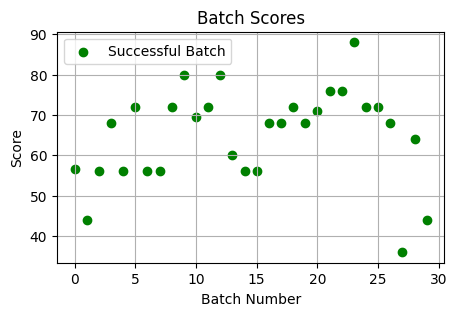

In [11]:
import matplotlib.pyplot as plt

trial_logs = compiled_program.trial_logs

# Extracting trial numbers, scores, and pruning status
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]
pruning_status = [trial_logs[trial]['pruned'] for trial in trial_numbers]

# Plot setup
plt.figure(figsize=(5, 3))

# Plotting each point
for trial_number, score, pruned in zip(trial_numbers, scores, pruning_status):
    if pruned:
        plt.scatter(trial_number, score, color='grey', label='Pruned Batch' if 'Pruned Batch' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.title('Batch Scores')
plt.grid(True)
plt.legend()
plt.show()

We can also __visualize the best prompts__ discovered by MIPRO as our trials progress... (though note that score increases are also due to the selected fewshot examples, which are not shown here for conciseness).

In [12]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(program.predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in compiled_program.trial_logs:
    program_score = compiled_program.trial_logs[trial_num]["score"]
    program_pruned = compiled_program.trial_logs[trial_num]["pruned"]
    if program_score > best_score and not program_pruned and compiled_program.trial_logs[trial_num]["full_eval"]:
        best_score = program_score
        best_program_so_far = compiled_program.trial_logs[trial_num]["program"]
    if trial_num % 5 == 0:
        print(f"Best program after {trial_num} batches | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Baseline program | Score: 0:
Prompt 1 Instruction: context, question -> answer

----------------
Best program after 0 batches | Score: 56.5:
Prompt 1 Instruction: Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

Best program after 5 batches | Score: 56.5:
Prompt 1 Instruction: Provide a yes or no answer based on the given context and question. The context and question are used as input to generate the answer.

Best program after 10 batches | Score: 69.5:
Prompt 1 Instruction: Given the context and question, generate a logical answer based on the reasoning process.

Best program after 15 batches | Score: 69.5:
Prompt 1 Instruction: Given the context and question, generate a logical answer based on the reasoning process.

Best program after 20 batches | Score: 71.0:
Prompt 1 Instruction: Determine if it can be logically concluded that a kayak is nearby based on the given context and question, and gener

#### 3d] Saving your program for later use

Now that we've gone through all this work of compiling a program it would be a shame to throw it away.  Fortunately we don't have to.  We can save your compiled program to disk with .save()!

This file is also human interpretable, so it's worth taking a look at the optimized program.  You can load it later with .load() on a program with the same modules.

In [13]:
compiled_program.save("compiled_program.dspy")